In [51]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import string

import scipy as sp
from scipy import sparse
import sklearn
from sklearn.decomposition import TruncatedSVD

from openTSNE import TSNE
from openTSNE import affinity, initialization, TSNEEmbedding
from openTSNE.affinity import Affinities

import time
import pickle

import memory_profiler

%load_ext memory_profiler

from pathlib import Path

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [52]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [53]:
%load_ext autoreload
%autoreload 2

from pubmed_landscape_src.plotting import *
from pubmed_landscape_src.metrics import knn_accuracy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
variables_path = Path("../../results/variables/bert-models")
figures_path = Path("../../results/figures/bert-models")
berenslab_data_path = Path(
    "/gpfs01/berens/data/data/pubmed_processed/embeddings/embeddings_luca"
)

In [55]:
plt.style.use("../matplotlib_style.txt")

Pipeline from PubMedBERT embeddings to two dimensional embedding

# Import data

In [56]:
# Import
df = pd.read_pickle(
    "/gpfs01/berens/data/data/pubmed_processed/df_labeled_papers_subset"
)
df = df.reset_index(drop=True)
colors = df["Colors"].to_numpy()

# t-SNE

Ran in ber1

In [57]:
def run_tsne(
    embeddings, model_name, variables_path, rs=42, save_intermediates=False
):
    # affinities
    A = affinity.Uniform(
        embeddings,
        k_neighbors=10,
        n_jobs=-1,
        verbose=1,
        random_state=42,
    )

    # initialization
    I = initialization.pca(embeddings, random_state=42)

    if save_intermediates == True:
        affinities_name = "affinities_P_" + model_name
        sp.sparse.save_npz(variables_path / affinities_name, A.P)

        initialization_name = "initialization_" + model_name
        np.save(variables_path / initialization_name, I)

    # t-SNE optimization
    E = TSNEEmbedding(I, A, n_jobs=-1, random_state=42, verbose=True)

    ## early exaggeration
    E = E.optimize(
        n_iter=125, exaggeration=12, momentum=0.5, n_jobs=-1, verbose=True
    )

    ## exaggeration annealing
    exs = np.linspace(12, 1, 125)
    for i in range(125):
        E = E.optimize(
            n_iter=1,
            exaggeration=exs[i],
            momentum=0.8,
            n_jobs=-1,
            verbose=True,
        )

    ## final optimization without exaggeration
    E = E.optimize(
        n_iter=500, exaggeration=1, momentum=0.8, n_jobs=-1, verbose=True
    )

    tsne = np.array(E)

    # save
    tsne_name = "tsne_" + model_name
    np.save(variables_path / tsne_name, tsne)

    return tsne

In [8]:
# DO NOT use the commented out ones. I reran them and they are in another directory.
representations = [
    # "abstracts_embeddings_float",
    "vec_av_simcse_float",
    "vec_av_biobert_float",
    #"vec_av_pubmed_float",
    "vec_av_scibert_float",
    "vec_av_specter_float",
    #"vec_cls_bertbase_float",
    "vec_cls_simcse_float",
    "vec_cls_biobert_float",
    #"vec_cls_pubmed_float",
    "vec_cls_scibert_float",
    "vec_cls_specter_float",
    #"vec_sep_bertbase_float",
    "vec_sep_simcse_float",
    "vec_sep_biobert_float",
    #"vec_sep_pubmed_float",
    "vec_sep_scibert_float",
    "vec_sep_specter_float",
]

In [ ]:
%%capture cap
%%time

for rep_name in representations:
    np.save(variables_path / "iter_rep", np.array(rep_name))

    # load
    rep_file = rep_name + ".npy"
    rep = np.load(berenslab_data_path / rep_file)
    print(rep_name)

    # t-SNE
    start = time.time()
    tsne = run_tsne(
        rep, rep_name, variables_path, rs=42, save_intermediates=True
    )
    end = time.time()
    print("Time: ", end - start)

tcmalloc: large alloc 1536000000 bytes == 0x187ce6000 @ 
tcmalloc: large alloc 1916911616 bytes == 0x25c510000 @ 
tcmalloc: large alloc 2491990016 bytes == 0x2ce92c000 @ 
tcmalloc: large alloc 3239583744 bytes == 0x2046d2000 @ 
tcmalloc: large alloc 4211466240 bytes == 0x3c301a000 @ 
tcmalloc: large alloc 6144000000 bytes == 0x4be078000 @ 
tcmalloc: large alloc 3239583744 bytes == 0x4578a6000 @ 
tcmalloc: large alloc 4211466240 bytes == 0x518a28000 @ 
tcmalloc: large alloc 6144000000 bytes == 0x62cbd8000 @ 
tcmalloc: large alloc 4211466240 bytes == 0x3c301a000 @ 
tcmalloc: large alloc 6144000000 bytes == 0x62cbd8000 @ 


In [ ]:
with open(variables_path / "verbose_tsnes_luca.txt", "w") as f:
    f.write(cap.stdout)

In [9]:
%%time

# SciNCL
path = (
    "/gpfs01/berens/data/data/pubmed_processed/embeddings/embeddings_malteos/"
)
representations = ["embeddings_av", "embeddings_cls", "embeddings_sep"]

for rep_name in representations:
    # load
    rep_file = path + rep_name + ".npy"
    rep = np.load(rep_file)
    print(rep_name)

    # t-SNE
    start = time.time()
    tsne_name = "scincl_" + rep_name
    tsne = run_tsne(
        rep, tsne_name, variables_path, rs=42, save_intermediates=True
    )
    end = time.time()
    print("Time: ", end - start)

tcmalloc: large alloc 6144000000 bytes == 0x173182000 @ 


embeddings_av
===> Finding 10 nearest neighbors using Annoy approximate search using euclidean distance...


tcmalloc: large alloc 1474551808 bytes == 0x53a6e000 @ 
tcmalloc: large alloc 1916911616 bytes == 0xab8ac000 @ 
tcmalloc: large alloc 2491990016 bytes == 0x100b6000 @ 
tcmalloc: large alloc 3239583744 bytes == 0xa4942000 @ 
tcmalloc: large alloc 4211466240 bytes == 0x2e1ce2000 @ 


   --> Time elapsed: 433.85 seconds


tcmalloc: large alloc 6144000000 bytes == 0x3dd540000 @ 


===> Running optimization with exaggeration=12.00, lr=83333.33 for 125 iterations...
Iteration   50, KL divergence 10.1213, 50 iterations in 19.5248 sec
Iteration  100, KL divergence 9.7211, 50 iterations in 20.5116 sec
   --> Time elapsed: 50.79 seconds
===> Running optimization with exaggeration=12.00, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.37 seconds
===> Running optimization with exaggeration=11.91, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.37 seconds
===> Running optimization with exaggeration=11.82, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.35 seconds
===> Running optimization with exaggeration=11.73, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.37 seconds
===> Running optimization with exaggeration=11.65, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.39 seconds
===> Running optimization with exaggeration=11.56, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.35 seconds
===> Running optimization with exaggeration

tcmalloc: large alloc 6144000000 bytes == 0x3dd540000 @ 


embeddings_cls
===> Finding 10 nearest neighbors using Annoy approximate search using euclidean distance...


tcmalloc: large alloc 3239583744 bytes == 0x2e1ce2000 @ 
tcmalloc: large alloc 4211466240 bytes == 0x173182000 @ 


   --> Time elapsed: 428.91 seconds


tcmalloc: large alloc 6144000000 bytes == 0x54c0a0000 @ 


===> Running optimization with exaggeration=12.00, lr=83333.33 for 125 iterations...
Iteration   50, KL divergence 10.0812, 50 iterations in 19.8416 sec
Iteration  100, KL divergence 9.6451, 50 iterations in 20.7613 sec
   --> Time elapsed: 51.29 seconds
===> Running optimization with exaggeration=12.00, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.36 seconds
===> Running optimization with exaggeration=11.91, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.36 seconds
===> Running optimization with exaggeration=11.82, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.35 seconds
===> Running optimization with exaggeration=11.73, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.37 seconds
===> Running optimization with exaggeration=11.65, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.35 seconds
===> Running optimization with exaggeration=11.56, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.36 seconds
===> Running optimization with exaggeration

tcmalloc: large alloc 6144000000 bytes == 0x54c0a0000 @ 


embeddings_sep
===> Finding 10 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 428.80 seconds


tcmalloc: large alloc 6144000000 bytes == 0x3dd540000 @ 


===> Running optimization with exaggeration=12.00, lr=83333.33 for 125 iterations...
Iteration   50, KL divergence 10.0805, 50 iterations in 18.8685 sec
Iteration  100, KL divergence 9.6453, 50 iterations in 20.9563 sec
   --> Time elapsed: 50.43 seconds
===> Running optimization with exaggeration=12.00, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.42 seconds
===> Running optimization with exaggeration=11.91, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.39 seconds
===> Running optimization with exaggeration=11.82, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.40 seconds
===> Running optimization with exaggeration=11.73, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.39 seconds
===> Running optimization with exaggeration=11.65, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.38 seconds
===> Running optimization with exaggeration=11.56, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.41 seconds
===> Running optimization with exaggeration

In [10]:
%%time

# SBERT
path = "/gpfs01/berens/data/data/pubmed_processed/embeddings/embeddings_SBERT/"
representations = ["embeddings_av", "embeddings_cls", "embeddings_sep"]

for rep_name in representations:
    # load
    rep_file = path + rep_name + ".npy"
    rep = np.load(rep_file)
    print(rep_name)

    # t-SNE
    start = time.time()
    tsne_name = "sbert_" + rep_name
    tsne = run_tsne(
        rep, tsne_name, variables_path, rs=42, save_intermediates=True
    )
    end = time.time()
    print("Time: ", end - start)

tcmalloc: large alloc 6144000000 bytes == 0x3dd540000 @ 


embeddings_av
===> Finding 10 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 427.55 seconds
===> Running optimization with exaggeration=12.00, lr=83333.33 for 125 iterations...
Iteration   50, KL divergence 10.1814, 50 iterations in 20.0550 sec
Iteration  100, KL divergence 9.7388, 50 iterations in 20.8491 sec
   --> Time elapsed: 51.39 seconds
===> Running optimization with exaggeration=12.00, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.36 seconds
===> Running optimization with exaggeration=11.91, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.39 seconds
===> Running optimization with exaggeration=11.82, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.37 seconds
===> Running optimization with exaggeration=11.73, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.36 seconds
===> Running optimization with exaggeration=11.65, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.35 seconds
===> Running opti

In [58]:
%%time

# PubMedBERT
path = "/gpfs01/berens/data/data/pubmed_processed/embeddings/embeddings_PubMedBERT/"
representations = ["embeddings_av", "embeddings_cls", "embeddings_sep"]

for rep_name in representations:
    # load
    rep_file = path + rep_name + ".npy"
    rep = np.load(rep_file)
    print(rep_name)

    # t-SNE
    start = time.time()
    tsne_name = "pubmedbert_" + rep_name
    tsne = run_tsne(
        rep, tsne_name, variables_path, rs=42, save_intermediates=True
    )
    end = time.time()
    print("Time: ", end - start)

embeddings_av
===> Finding 10 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 422.95 seconds
===> Running optimization with exaggeration=12.00, lr=83333.33 for 125 iterations...
Iteration   50, KL divergence 10.2440, 50 iterations in 17.6066 sec
Iteration  100, KL divergence 9.9124, 50 iterations in 20.9299 sec
   --> Time elapsed: 48.75 seconds
===> Running optimization with exaggeration=12.00, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.34 seconds
===> Running optimization with exaggeration=11.91, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.37 seconds
===> Running optimization with exaggeration=11.82, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.39 seconds
===> Running optimization with exaggeration=11.73, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.39 seconds
===> Running optimization with exaggeration=11.65, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.41 seconds
===> Running opti

In [59]:
%%time

# BERT
path = "/gpfs01/berens/data/data/pubmed_processed/embeddings/embeddings_BERT/"
representations = ["embeddings_av", "embeddings_cls", "embeddings_sep"]

for rep_name in representations:
    # load
    rep_file = path + rep_name + ".npy"
    rep = np.load(rep_file)
    print(rep_name)

    # t-SNE
    start = time.time()
    tsne_name = "bert_" + rep_name
    tsne = run_tsne(
        rep, tsne_name, variables_path, rs=42, save_intermediates=True
    )
    end = time.time()
    print("Time: ", end - start)

embeddings_av
===> Finding 10 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 426.07 seconds
===> Running optimization with exaggeration=12.00, lr=83333.33 for 125 iterations...
Iteration   50, KL divergence 10.1536, 50 iterations in 19.9412 sec
Iteration  100, KL divergence 9.7242, 50 iterations in 20.1820 sec
   --> Time elapsed: 50.72 seconds
===> Running optimization with exaggeration=12.00, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.39 seconds
===> Running optimization with exaggeration=11.91, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.39 seconds
===> Running optimization with exaggeration=11.82, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.38 seconds
===> Running optimization with exaggeration=11.73, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.38 seconds
===> Running optimization with exaggeration=11.65, lr=83333.33 for 1 iterations...
   --> Time elapsed: 0.38 seconds
===> Running opti

# kNN accuracies

Ran in gber3

In [8]:
# DO NOT use the commented out ones. I reran them and they are in another directory.
representations = [
    # "abstracts_embeddings_float",
    "vec_av_simcse_float",
    "vec_av_biobert_float",
    #"vec_av_pubmed_float",
    "vec_av_scibert_float",
    "vec_av_specter_float",
    #"vec_cls_bertbase_float",
    "vec_cls_simcse_float",
    "vec_cls_biobert_float",
    #"vec_cls_pubmed_float",
    "vec_cls_scibert_float",
    "vec_cls_specter_float",
    #"vec_sep_bertbase_float",
    "vec_sep_simcse_float",
    "vec_sep_biobert_float",
    #"vec_sep_pubmed_float",
    "vec_sep_scibert_float",
    "vec_sep_specter_float",
]

In [19]:
%%time

for rep_name in representations:
    # load
    tsne_name = "tsne_" + rep_name + ".npy"
    tsne = np.load(variables_path / tsne_name)
    print(rep_name)

    # kNN accuracy
    start = time.time()
    knn_accuracy_tsne = knn_accuracy_ls(tsne, colors)  # , subset_size=10000)
    knn_accuracy_name = "knn_accuracy_tsne_" + rep_name
    np.save(variables_path / knn_accuracy_name, knn_accuracy_tsne)
    print("kNN accuracy: ", knn_accuracy_tsne)
    end = time.time()
    print("Time: ", end - start)

vec_av_bert_float
kNN accuracy:  0.4687
Time:  262.07989144325256
vec_av_biobert_float
kNN accuracy:  0.5468
Time:  239.69859218597412
vec_av_pubmed_float
kNN accuracy:  0.5337
Time:  262.54199981689453
vec_av_scibert_float
kNN accuracy:  0.5231
Time:  242.33471655845642
vec_av_specter_float
kNN accuracy:  0.5843
Time:  267.6873970031738
vec_cls_bertbase_float
kNN accuracy:  0.3577
Time:  267.57766938209534
vec_cls_bert_float
kNN accuracy:  0.4239
Time:  245.12337446212769
vec_cls_biobert_float
kNN accuracy:  0.5111
Time:  250.74200057983398
vec_cls_pubmed_float
kNN accuracy:  0.6099
Time:  250.79098200798035
vec_cls_scibert_float
kNN accuracy:  0.4338
Time:  250.34273481369019
vec_cls_specter_float
kNN accuracy:  0.5915
Time:  253.98711252212524
vec_sep_bertbase_float
kNN accuracy:  0.4128
Time:  267.04066610336304
vec_sep_bert_float
kNN accuracy:  0.4032
Time:  260.07835483551025
vec_sep_biobert_float
kNN accuracy:  0.565
Time:  261.9296462535858
vec_sep_pubmed_float
kNN accuracy:  0

In [22]:
%%time

# SciNCL
representations = ["embeddings_av", "embeddings_cls", "embeddings_sep"]

for rep_name in representations:
    # load
    tsne_name = "tsne_scincl_" + rep_name + ".npy"
    tsne = np.load(variables_path / tsne_name)
    print(rep_name)

    # kNN accuracy
    start = time.time()
    knn_accuracy_tsne = knn_accuracy_ls(tsne, colors)  # , subset_size=10000)
    knn_accuracy_name = "knn_accuracy_tsne_scincl_" + rep_name
    np.save(variables_path / knn_accuracy_name, knn_accuracy_tsne)
    print("kNN accuracy: ", knn_accuracy_tsne)
    end = time.time()
    print("Time: ", end - start)

embeddings_av
kNN accuracy:  0.6067
Time:  254.02697372436523
embeddings_cls
kNN accuracy:  0.5906
Time:  249.51035046577454
embeddings_sep
kNN accuracy:  0.5938
Time:  255.61739945411682
CPU times: user 35min 19s, sys: 1h 49s, total: 1h 36min 8s
Wall time: 12min 39s


In [23]:
%%time

# SBERT
representations = ["embeddings_av", "embeddings_cls", "embeddings_sep"]

for rep_name in representations:
    # load
    tsne_name = "tsne_sbert_" + rep_name + ".npy"
    tsne = np.load(variables_path / tsne_name)
    print(rep_name)

    # kNN accuracy
    start = time.time()
    knn_accuracy_tsne = knn_accuracy_ls(tsne, colors)  # , subset_size=10000)
    knn_accuracy_name = "knn_accuracy_tsne_sbert_" + rep_name
    np.save(variables_path / knn_accuracy_name, knn_accuracy_tsne)
    print("kNN accuracy: ", knn_accuracy_tsne)
    end = time.time()
    print("Time: ", end - start)

embeddings_av
kNN accuracy:  0.6015
Time:  269.95675444602966
embeddings_cls
kNN accuracy:  0.5633
Time:  274.9900722503662
embeddings_sep
kNN accuracy:  0.5668
Time:  253.56682920455933
CPU times: user 34min 15s, sys: 57min 46s, total: 1h 32min 1s
Wall time: 13min 18s


In [8]:
%%time

# PubMedBERT
representations = ["embeddings_av", "embeddings_cls", "embeddings_sep"]

for rep_name in representations:
    # load
    tsne_name = "tsne_pubmedbert_" + rep_name + ".npy"
    tsne = np.load(variables_path / tsne_name)
    print(rep_name)

    # kNN accuracy
    start = time.time()
    knn_accuracy_tsne = knn_accuracy_ls(tsne, colors)  # , subset_size=10000)
    knn_accuracy_name = "knn_accuracy_tsne_pubmedbert_" + rep_name
    np.save(variables_path / knn_accuracy_name, knn_accuracy_tsne)
    print("kNN accuracy: ", knn_accuracy_tsne)
    end = time.time()
    print("Time: ", end - start)

embeddings_av
kNN accuracy:  0.5319
Time:  245.2310516834259
embeddings_cls
kNN accuracy:  0.4554
Time:  240.5460045337677
embeddings_sep
kNN accuracy:  0.6076
Time:  259.2988193035126
CPU times: user 36min 43s, sys: 1h 3min 18s, total: 1h 40min 1s
Wall time: 12min 25s


In [10]:
%%time

# BERT
representations = ["embeddings_av", "embeddings_cls", "embeddings_sep"]

for rep_name in representations:
    # load
    tsne_name = "tsne_bert_" + rep_name + ".npy"
    tsne = np.load(variables_path / tsne_name)
    print(rep_name)

    # kNN accuracy
    start = time.time()
    knn_accuracy_tsne = knn_accuracy_ls(tsne, colors)  # , subset_size=10000)
    knn_accuracy_name = "knn_accuracy_tsne_bert_" + rep_name
    np.save(variables_path / knn_accuracy_name, knn_accuracy_tsne)
    print("kNN accuracy: ", knn_accuracy_tsne)
    end = time.time()
    print("Time: ", end - start)

embeddings_av
kNN accuracy:  0.4599
Time:  258.8440577983856
embeddings_cls
kNN accuracy:  0.3627
Time:  256.19560408592224
embeddings_sep
kNN accuracy:  0.4056
Time:  254.7977933883667
CPU times: user 36min 56s, sys: 1h 39s, total: 1h 37min 35s
Wall time: 12min 50s


# Plot

Ran in ber1

In [8]:
# DO NOT use the commented out ones. I reran them and they are in another directory.
representations = [
    # "abstracts_embeddings_float",
    "vec_av_simcse_float",
    "vec_av_biobert_float",
    #"vec_av_pubmed_float",
    "vec_av_scibert_float",
    "vec_av_specter_float",
    #"vec_cls_bertbase_float",
    "vec_cls_simcse_float",
    "vec_cls_biobert_float",
    #"vec_cls_pubmed_float",
    "vec_cls_scibert_float",
    "vec_cls_specter_float",
    #"vec_sep_bertbase_float",
    "vec_sep_simcse_float",
    "vec_sep_biobert_float",
    #"vec_sep_pubmed_float",
    "vec_sep_scibert_float",
    "vec_sep_specter_float",
]

In [64]:
dict_bert_accuracies = {
    "bert": [57.1, 50.4, 53.4],
    "scibert": [62.1, 57.0, 60.9],
    "biobert": [64.0, 62.7, 65.0],
    "pubmedbert": [64.4, 60.4, 67.7],
    "sbert": [64.5, 60.7, 62.2],
    "specter": [64.6, 63.9, 64.7],
    "scincl": [65.0, 64.6, 64.6],
    "simcse": [57.0, 53.2, 52.1],  # SimCSE
}

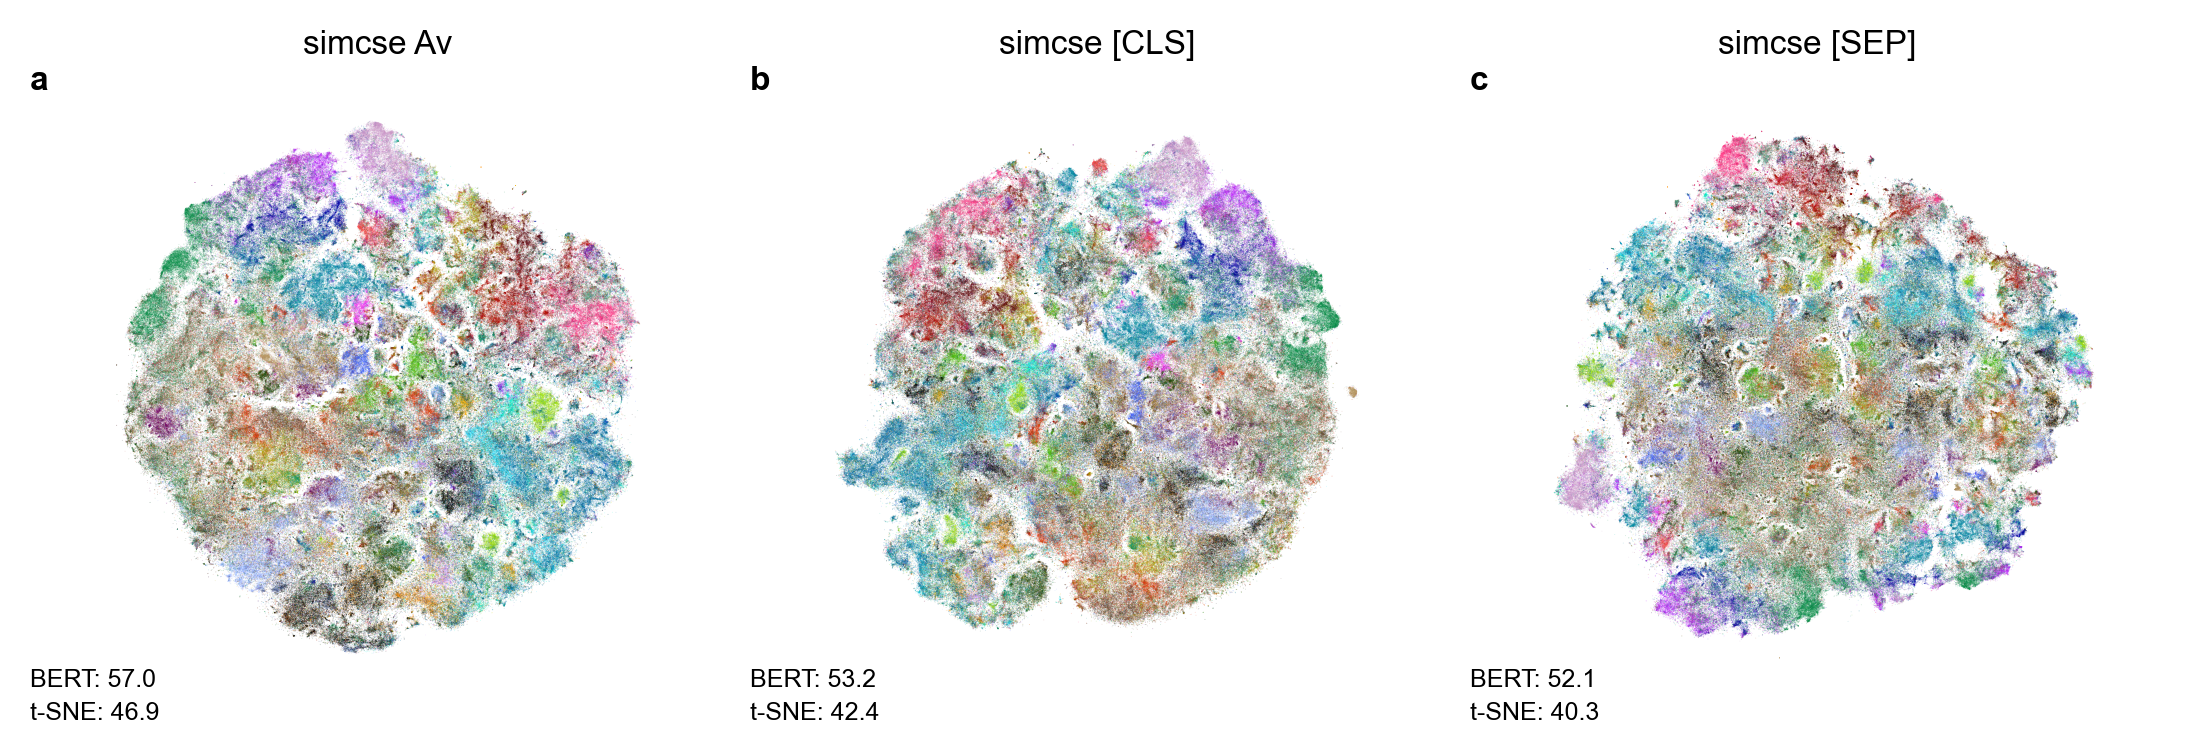

In [65]:
# Luca's data
models = [
    "simcse",
    # "biobert",
    # "scibert",
    # "specter",
]

for model_name in models:
    %matplotlib inline
    fig, axs = plt.subplots(
        1,
        3,
        figsize=(7.2, 2.4),
        layout="constrained",
        sharey=True,
        dpi=300,
    )

    txt_kwargs = dict(size=8, weight="bold", va="top", ha="left")
    x_lim = (-100, 100)
    y_lim = (-100, 100)

    beginning = ["vec_av_", "vec_cls_", "vec_sep_"]
    titles = [" Av", " [CLS]", " [SEP]"]

    for i, ax in enumerate(axs.flat):
        # load
        tsne_name = "tsne_" + beginning[i] + model_name + "_float.npy"
        tsne = np.load(variables_path / tsne_name)

        knn_accuracy_name = (
            "knn_accuracy_tsne_" + beginning[i] + model_name + "_float.npy"
        )
        knn_accuracy_tsne = np.load(variables_path / knn_accuracy_name)

        # plot
        plot_tsne_colors(
            tsne,
            colors,
            x_lim=x_lim,
            y_lim=y_lim,
            ax=ax,
            plot_type="subplot_2",
            axis_on=False,
        )
        ax.text(
            0,
            1,
            string.ascii_lowercase[i],
            transform=ax.transAxes,
            **txt_kwargs,
        )

        # knn accuracies
        ax.text(
            0,
            0,
            f"t-SNE: {knn_accuracy_tsne*100:.1f}",
            transform=ax.transAxes,
            va="bottom",
            ha="left",
            size=6,
        )
        ax.text(
            0,
            0.05,
            f"BERT: {dict_bert_accuracies[model_name][i]}",
            transform=ax.transAxes,
            va="bottom",
            ha="left",
            size=6,
        )

        title = model_name + titles[i]
        ax.set_title(title)

    # figname_pdf = "tsne_" + model_name + ".pdf"
    figname_png = "tsne_" + model_name + ".png"
    # fig.savefig(figures_path / figname_pdf)
    fig.savefig(figures_path / figname_png)

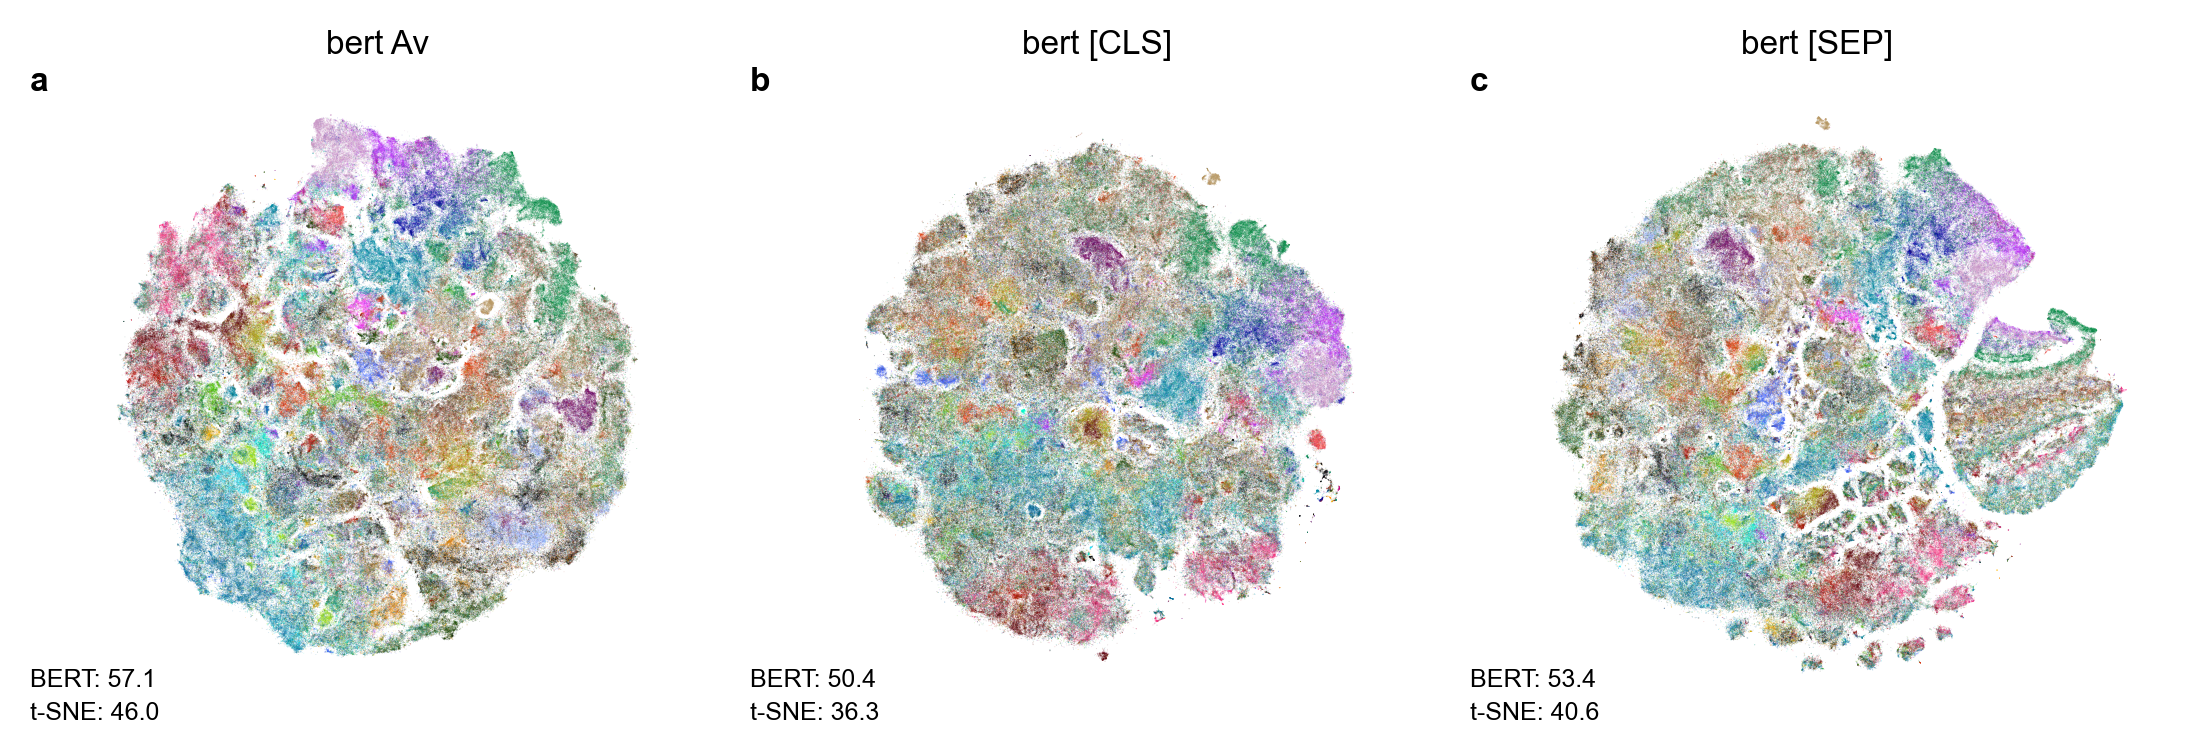

In [72]:
# my data
models = [
    # "sbert",
    # "scincl",
    "bert",
    # "pubmedbert",
]

for model_name in models:
    %matplotlib inline
    fig, axs = plt.subplots(
        1,
        3,
        figsize=(7.2, 2.4),
        layout="constrained",
        sharey=True,
        dpi=300,
    )

    txt_kwargs = dict(size=8, weight="bold", va="top", ha="left")
    x_lim = (-100, 100)
    y_lim = (-100, 100)

    representations = ["_embeddings_av", "_embeddings_cls", "_embeddings_sep"]
    titles = [" Av", " [CLS]", " [SEP]"]

    for i, ax in enumerate(axs.flat):
        # load

        tsne_name = "tsne_" + model_name + representations[i] + ".npy"
        tsne = np.load(variables_path / tsne_name)

        # knn_accuracy_name = (
        #    "knn_accuracy_tsne_" + beginning[i] + model_name + "_float.npy"
        # )
        knn_accuracy_name = (
            "knn_accuracy_tsne_" + model_name + representations[i] + ".npy"
        )
        knn_accuracy_tsne = np.load(variables_path / knn_accuracy_name)

        # plot
        plot_tsne_colors(
            tsne,
            colors,
            x_lim=x_lim,
            y_lim=y_lim,
            ax=ax,
            plot_type="subplot_2",
            axis_on=False,
        )
        ax.text(
            0,
            1,
            string.ascii_lowercase[i],
            transform=ax.transAxes,
            **txt_kwargs,
        )

        # knn accuracies
        ax.text(
            0,
            0,
            f"t-SNE: {knn_accuracy_tsne*100:.1f}",
            transform=ax.transAxes,
            va="bottom",
            ha="left",
            size=6,
        )
        ax.text(
            0,
            0.05,
            f"BERT: {dict_bert_accuracies[model_name][i]}",
            transform=ax.transAxes,
            va="bottom",
            ha="left",
            size=6,
        )

        title = model_name + titles[i]

        ax.set_title(title)  # , y=ys[i])

    # figname_pdf = "tsne_" + model_name + ".pdf"
    figname_png = "tsne_" + model_name + ".png"
    # fig.savefig(figures_path / figname_pdf)
    fig.savefig(figures_path / figname_png)